In [14]:
# Imports
from scipy import sparse
import scipy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time
from numpy import linalg as LA

# Frank-Wolfe - standard algorithm

In [2]:
# FW objective function
def FW_objective_function(diff_vec):
    return 0.5*(np.power(diff_vec,2).sum())

# Regular FW algorithm
def FrankWolfe(X, objective_function, delta, empties = 0, printing_res = True, Z_init = None, max_iter = 150, patience = 1e-3):
    '''
    :param X: sparse matrix with ratings and 'empty values', rows - users, columns - books.
    :param objective_function: objective function that we would like to minimize with FW
    :param delta: Radius of the feasible's set ball
    :param empties (optional): Empty values of X are zeros (0) or NaN ('nan'). Default = 0
    :param Z_init (optional): In case we want to initialize Z with a known matrix, if not given Z_init will be a zeros matrix. Default = None.
    :param max_iter (optional): max number of iterations for the method. Default = 150.
    :param patience (optional): once reached this tolerance provide the result. Default = 1e-3.
    :return: Z: matrix of predicted ratings - it should be like X but with no 'empty values'
    :return: accuracy: difference between original values (X) and predicted ones (Z)
    '''

    # Get X indexes for not empty values
    if empties == 0:
        idx_ratings = np.argwhere(X != 0)
    elif empties == 'nan':
        idx_ratings = np.argwhere(~np.isnan(X))
    else:
        return print('Error: Empties argument', empties, 'not valid.')

    idx_rows = idx_ratings[:,0]
    idx_cols = idx_ratings[:,1]

    # Initialize Z
    if Z_init == 'random uniform':
        Z = np.random.uniform(low = 0.01, high = 1, size = X.shape)
    elif Z_init is not None:
        Z = Z_init
    else:
        Z = np.zeros(X.shape)

    # Create vectors with the not empty features of the sparse matrix
    X_rated = X[idx_rows, idx_cols]
    Z_rated = Z[idx_rows, idx_cols]
    diff_vec = np.array(Z_rated - X_rated)[0]

    # Create needed variables
    res_list = []
    diff_loss = patience + 1
    loss = objective_function(diff_vec)
    it = 0
    while (diff_loss > patience) and (it < max_iter):

        # Gradient
        grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))

        # SVD - Compute k = 1 singular values and its vectors, starting from the largest (which = 'LM')
        u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')   #

        # Update
        Zk_tilde = -delta*np.outer(u_max,v_max)

        alpha_k = 2/(it+2) #alpha - as studied in class
        Z = (1-alpha_k)*Z + alpha_k*Zk_tilde

        # Loss
        diff_vec = np.array(Z[idx_rows, idx_cols] - X_rated)[0]
        new_loss = objective_function(diff_vec)

        # Improvement at this iteration
        diff_loss = np.abs(loss - new_loss)
        loss = new_loss

        if printing_res == True:
            if it == 1 or it % 10 == 0:
                print('Iteration:', it, 'Loss:', loss, 'Loss diff:', diff_loss, 'Rank(Z): ', np.linalg.matrix_rank(Z))

        # Count iteration
        it += 1

        res_list.append(loss)
        
    return Z, loss, res_list

# Frank-Wolfe In-face

In [3]:
time_out = time.process_time() + 5

In [35]:
# Binary search for alpha stop
def alpha_binary_search(Zk, Dk, delta, max_value = 1, min_value = 0, tol = 0.3):

    #Inizialization

    best_alpha = (max_value - min_value) / 2

    testing_matrix = Zk + best_alpha * Dk

    sentinel = False

    while time.process_time() <= time_out:

      testing_mat_nuclear_norm = LA.norm(testing_matrix, ord = 'nuc')

      sentinel = True

    #Binary Search

    if sentinel == True:

      while testing_mat_nuclear_norm <= delta and (max_value - min_value) >= tol and time.process_time() <= time_out:

          min_value = best_alpha

          best_alpha = (max_value - min_value) / 2

          testing_matrix = Zk + best_alpha * Dk

          testing_mat_nuclear_norm = LA.norm(testing_matrix, ord = 'nuc')

    return best_alpha

In [111]:
def FW_inface(X, objective_function, delta, L = 1, D = None, gamma1 = 0, gamma2 = 1, THRES = 0.001, empties = 0, max_iter=150, patience=1e-3, printing = True):
    '''
    :param X: sparse matrix with ratings and 'empty values', rows - users, columns - books.
    :param objective_function: objective function that we would like to minimize with FW.
    :param delta: Radius of the feasible's set ball
    :param L: must be greater than 1
    :param D: if not inputed = 2*delta
    :param gamma1:
    :param gamma2:
    :param THRES:
    :param empties (optional): Empty values of X are zeros (0) or NaN ('nan'). Default = 0
    :param max_iter: max number of iterations for the method.
    :param patience: once reached this tolerance provide the result.
    :return: Z: matrix of predicted ratings - it should be like X but with no 'empty values'
            loss: difference between original values (X) and predicted ones (Z).
    '''

    # Get X indexes for not empty values
    if empties == 0:
        idx_ratings = np.argwhere(X != 0)
    elif empties == 'nan':
        idx_ratings = np.argwhere(~np.isnan(X))
    else:
        return print('Empties argument', empties, 'not valid.')

    idx_rows = idx_ratings[:,0]
    idx_cols = idx_ratings[:,1]

    # Initialize Z_{-1}
    Z0 = np.zeros(X.shape)

    # Create vectors with the not empty features of the sparse matrix
    X_rated = X[idx_rows, idx_cols]
    Z_rated = Z0[idx_rows, idx_cols]
    diff_vec = np.array(Z_rated - X_rated)[0]

    # Initial gradient and Z0
    grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))
    u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')
    Zk = -delta*np.outer(u_max,v_max)
    Z_rated = Zk[idx_rows, idx_cols]

    print('Initial Zk Rank: ', LA.matrix_rank(Zk))

    # Initialize lower bound on the optimal objective function (f*)
    diff_vec = np.array(Z_rated - X_rated)[0]
    new_low_bound = np.max((objective_function(diff_vec) + np.multiply(diff_vec,Z_rated)), 0).sum()
    #new_low_bound = 0 #used 0 otherwise the other new_low_bound was too high!

    # Set D
    if D is not None:
        D = D
    else:
        D = 2*delta

    rank_Z = LA.matrix_rank(Zk)   # rank of Zk to find thin SVD size

    # Additional needed parameters
    diff_loss = patience + 1
    loss = objective_function(diff_vec)
    it = 0
    res_list = [loss]

    B_used = 0
    A_used = 0
    not_entered = 0
    regularFW = 0

    while (diff_loss > patience) and (it < max_iter):

        # Thin SVD
        U_thin, s_thin, Vh_thin = sparse.linalg.svds(Zk, k = rank_Z, which='LM')   # Compute k = rank singular values

        # Lower bound update
        low_bound = new_low_bound

        # In-face direction with the away step strategy: two calculations depending of where Z lies within the feasible set
        if s_thin.sum() <= delta: # Z in border (sum of singular values == radius of feasible set)
            print('Zk in border!')
            G = 0.5 * (Vh_thin.dot(grad.T.dot(U_thin)) + U_thin.T.dot(grad.dot(Vh_thin.T)))
            # Obtain unitary eigenvector corresponding to smallest eigenvalue of G
            #lamb, u = sparse.linalg.eigs(G, k = 1, which = 'SM')
            eigvalues, eigvectors = LA.eig(G)  #find the eigenvalues
            min_eig = np.argmin(eigvalues)  #find the index of the smallest eigenvalue
            u = eigvectors[:, min_eig]  #take the eigenvector corresponding to the smallest eigenvalue

            # Update value
            M = np.outer(u,u.T)
            Zk_tilde = delta*U_thin.dot(M.dot(Vh_thin))
            Dk = Zk - Zk_tilde
            #alpha_B = 0.5

            inv_s_thin = np.diag(1/s_thin)
            alpha_B = 1/(delta*u.T.dot(inv_s_thin).dot(u)-1)

        else: #inside
            grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))
            u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')
            Zk_tilde = delta*np.outer(u_max,v_max)
            Dk = Zk - Zk_tilde
            #BINARY SEARCH
            '''
            alpha_B = alpha_binary_search(Zk,
                                          Dk,
                                          delta)
            '''
            alpha_B = 0.5

        nuclear_norm = s_thin.sum()
        print('thres:', abs(delta - nuclear_norm))
        print('rank', rank_Z)
        if abs(delta - nuclear_norm) < THRES and rank_Z > 1:
            Z_B = Zk + alpha_B*Dk
            diff_vec_B = Z_B[idx_rows, idx_cols] - X_rated

            if 1/(objective_function(diff_vec_B)-low_bound) >= (1/(loss-low_bound)+gamma1/(2*L*D**2)):
              # 1. Move to a lower dimensional face
              print('Went to a lower-dimensional face')
              B_used += 1
              Zk = Z_B

            else:
                beta = alpha_B/5 # FIND A GOOD VALUE -- a binary search is also suggested by the paper
                Z_A = Zk + beta*Dk
                diff_vec_A = Z_A[idx_rows, idx_cols] - X_rated
                if 1/(objective_function(diff_vec_A)-low_bound) >= (1/(loss-low_bound)+gamma2/(2*L*D**2)):
                    # 2. Stay in the current face
                    print('Stayed in the current face')
                    A_used += 1
                    Zk = Z_A
                else:
                    # 3. Do a regular FW step and update the lower bound
                    print('Do a regular FW step')
                    regularFW += 1
                    #Zk update
                    grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))
                    u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')
                    Zk_tilde = -delta*np.outer(u_max,v_max)

                    '''# Lower bound update
                    B_w = loss + grad.T.dot(Zk_tilde - Zk)
                    print(B_w, low_bound)
                    new_low_bound = np.max(low_bound, B_w)'''

                    direction_vec = Zk_tilde.flatten() - Zk.flatten()
                    grad = grad.toarray()
                    wolfe_gap = grad.T.flatten() * direction_vec
                    B_w = loss + wolfe_gap.sum()

                    #TRIED THIS INSTEAD
                    if low_bound >= B_w:
                      new_low_bound = low_bound
                    else:
                      new_low_bound = B_w

                    # Z_(k+1)
                    alpha_k = 2/(it+2)
                    Zk = (1-alpha_k)*Zk + alpha_k*Zk_tilde

        else:

            # 3. Do a regular FW step and update the lower bound
            print('Do a regular FW step - not entered initial if')
            not_entered += 1
            #Zk update
            grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))
            u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')
            Zk_tilde = -delta*np.outer(u_max,v_max)

            '''# Lower bound update
            B_w = loss + grad.T.dot(Zk_tilde - Zk)
            print(B_w, low_bound)
            new_low_bound = np.max(low_bound, B_w)'''

            direction_vec = Zk_tilde.flatten() - Zk.flatten()
            grad = grad.toarray()
            wolfe_gap = grad.T.flatten() * direction_vec
            B_w = loss + wolfe_gap.sum()

            #TRIED THIS INSTEAD
            if low_bound >= B_w:
                new_low_bound = low_bound
            else:
                new_low_bound = B_w

            # Z_(k+1)
            alpha_k = 2/(it+2)
            Zk = (1-alpha_k)*Zk + alpha_k*Zk_tilde

        # Loss
        diff_vec = np.array(Zk[idx_rows, idx_cols] - X_rated)[0]
        new_loss = objective_function(diff_vec)

        # Improvement at this iteration
        diff_loss = np.abs(loss - new_loss)
        loss = new_loss

        rank_Z = LA.matrix_rank(Zk)   # rank of Zk to find thin SVD size

        # Gradient
        #grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))

        # Count iteration
        it += 1

        res_list.append(loss)

        if printing == True:
          if it % 1 == 0 or it == 1:
            print('Iteration:', it, 'Loss:', loss, 'Loss diff:', diff_loss, 'Rank(Z): ', rank_Z)
    print('Went to lower dim face:', B_used)
    print('Stayed:', A_used)
    print('Regular:', regularFW)
    print('Not entered if:', not_entered)
    return Zk, loss, res_list


In [112]:
pred_ratings, loss, res_listInFW = FW_inface(X_test, FW_objective_function, gamma1 = 0.05, gamma2 = 0.15, delta = 1, THRES = 10, max_iter = 100, patience = 1e-7)

Initial Zk Rank:  1
Zk in border!
thres: 3.3306690738754696e-16
rank 1
Do a regular FW step - not entered initial if
Iteration: 1 Loss: 0.5884274837060905 Loss diff: 0.3557793190841786 Rank(Z):  1
thres: 2.220446049250313e-16
rank 1
Do a regular FW step - not entered initial if
Iteration: 2 Loss: 0.3280182451599031 Loss diff: 0.26040923854618747 Rank(Z):  2
Zk in border!
thres: 0.1581994647578966
rank 2
Do a regular FW step
Iteration: 3 Loss: 0.2545835594764261 Loss diff: 0.073434685683477 Rank(Z):  3
Zk in border!
thres: 0.16669523549971332
rank 3
Do a regular FW step
Iteration: 4 Loss: 0.25797517047560814 Loss diff: 0.0033916109991820598 Rank(Z):  4
Zk in border!
thres: 0.10772017543507673
rank 4
Went to a lower-dimensional face
Iteration: 5 Loss: 0.2510203720733919 Loss diff: 0.006954798402216245 Rank(Z):  3
Zk in border!
thres: 0.17590905073120489
rank 3
Do a regular FW step
Iteration: 6 Loss: 0.2422039641819696 Loss diff: 0.008816407891422295 Rank(Z):  4
Zk in border!
thres: 0.125

C:\Users\cmart\AppData\Local\Temp\ipykernel_40660\3884968031.py:93: RuntimeWarning: divide by zero encountered in true_divide
  inv_s_thin = np.diag(1/s_thin)


thres: 0.018948440462874583
rank 20
Do a regular FW step
Iteration: 26 Loss: 0.1896859758633929 Loss diff: 0.0006979742284132229 Rank(Z):  21
Zk in border!
thres: 0.01755287646222048
rank 21
Do a regular FW step
Iteration: 27 Loss: 0.18926588325599594 Loss diff: 0.0004200926073969491 Rank(Z):  22
Zk in border!
thres: 0.016328038718359306
rank 22
Do a regular FW step
Iteration: 28 Loss: 0.1892537809083828 Loss diff: 1.2102347613146547e-05 Rank(Z):  23
Zk in border!
thres: 0.015224681637605375
rank 23
Do a regular FW step
Iteration: 29 Loss: 0.18867976350925414 Loss diff: 0.0005740173991286568 Rank(Z):  24
Zk in border!
thres: 0.014219414514206496
rank 24
Do a regular FW step
Iteration: 30 Loss: 0.18846069895847262 Loss diff: 0.00021906455078152254 Rank(Z):  25
Zk in border!
thres: 0.013342046868287882
rank 25
Do a regular FW step
Iteration: 31 Loss: 0.1886037172411087 Loss diff: 0.00014301828263607597 Rank(Z):  26
Zk in border!
thres: 0.0125236899478407
rank 26
Do a regular FW step
Iter

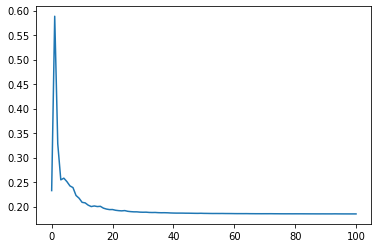

In [113]:
plt.plot(res_listInFW)
plt.show()

## Data Generation

In [101]:
# Parameters
n = 400
m = 200
r = 10
rho = 0.10
SNR = 5
delta = 3.75



# taking data
U = sparse.random(m, r, density=0.1, format='csr', data_rvs=None)
V = sparse.random(r, n, density=0.1, format='csr', data_rvs=None)
E = sparse.random(m, n, density=0.1, format='csr', data_rvs=None)



VT = V.transpose(copy=True)

UVT = U*V
#print(UVT. shape)

w1 = 1/(sparse.linalg.norm(UVT, ord='fro'))

w2 = 1/(SNR*sparse.linalg.norm(E, ord='fro'))

#Finally observed data matrix is:
X_test = w1*UVT + w2*E

# Non zero values
idx_ratings = np.argwhere(X_test != 0.)
idx_rows = idx_ratings[:,0]
idx_cols = idx_ratings[:,1]

# Nuclear norm of the test set
rank = np.linalg.matrix_rank(X_test)
U_thin, s_thin, Vh_thin = sparse.linalg.svds(X_test, k = rank, which='LM')
nuc_norm = s_thin.sum()

# Print some info about the generated data
print('Nuclear norm:', nuc_norm)
print('Data shape:', np.shape(X_test))
print('Number of observed values:', len(idx_rows))
print('Rank of the matrix:', rank)
print('Minimum and maximum values:', X_test.max(), X_test.min())

Nuclear norm: 0.5632052043683061
Data shape: (200, 400)
Number of observed values: 14942
Rank of the matrix: 1
Minimum and maximum values: 0.05306863232623509 0.0


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.


In [6]:
%time pred_ratings_reg, loss_reg, loss_track_reg = FrankWolfe(X_test, FW_objective_function, delta = 10, max_iter=100, patience=1e-7)

Iteration: 0 Loss: 20.710085461897688 Loss diff: 20.178013507822605 Rank(Z):  1
Iteration: 1 Loss: 8.136005495734203 Loss diff: 12.574079966163485 Rank(Z):  2
Iteration: 10 Loss: 0.5841890868123718 Loss diff: 0.5057625973947553 Rank(Z):  11
Iteration: 20 Loss: 0.38644839266838615 Loss diff: 0.12540854574466803 Rank(Z):  21
Iteration: 30 Loss: 0.27455173635972413 Loss diff: 0.039281464643407704 Rank(Z):  31
Iteration: 40 Loss: 0.14399512309815454 Loss diff: 0.02499449833787848 Rank(Z):  41
Iteration: 50 Loss: 0.09198025468452456 Loss diff: 0.0028837977552780697 Rank(Z):  51
Iteration: 60 Loss: 0.07665822248490584 Loss diff: 0.013324781893819443 Rank(Z):  61
Iteration: 70 Loss: 0.07333132593891507 Loss diff: 0.0006173570934196876 Rank(Z):  71
Iteration: 80 Loss: 0.052422250273545315 Loss diff: 0.0017050065465505915 Rank(Z):  81
Iteration: 90 Loss: 0.04357177196057917 Loss diff: 0.0007945935581365055 Rank(Z):  91
CPU times: total: 766 ms
Wall time: 750 ms


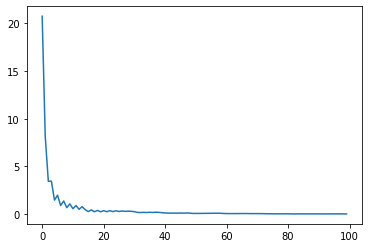

In [7]:
plt.plot(loss_track)
plt.show()

In [36]:
%time pred_ratings_inface, loss_inface, loss_track_inface = FW_inface(X_test, FW_objective_function, gamma1 = 0.25, gamma2 = 0.5, delta = 1, THRES = 10, max_iter = 100, patience = 1e-7)

rank 1
Do regular FW step
Iteration: 1 Loss: 0.5853282793478831 Loss diff: 49.525331316145206 Rank(Z):  1
Do regular FW step
Iteration: 2 Loss: 0.3537519534474485 Loss diff: 0.23157632590043464 Rank(Z):  1
Do regular FW step
Iteration: 3 Loss: 0.45288475571449016 Loss diff: 0.09913280226704169 Rank(Z):  1
Do regular FW step
Iteration: 4 Loss: 0.4304950862546344 Loss diff: 0.022389669459855766 Rank(Z):  1
Do regular FW step
Iteration: 5 Loss: 0.4321174627365453 Loss diff: 0.001622376481910881 Rank(Z):  1
Do regular FW step
Iteration: 6 Loss: 0.43225871872437643 Loss diff: 0.000141255987831157 Rank(Z):  1
Do regular FW step
Iteration: 7 Loss: 0.43228699437825624 Loss diff: 2.8275653879805684e-05 Rank(Z):  1
Do regular FW step
Iteration: 8 Loss: 0.4322951641290038 Loss diff: 8.169750747577531e-06 Rank(Z):  1
Do regular FW step
Iteration: 9 Loss: 0.43229810535310204 Loss diff: 2.941224098218509e-06 Rank(Z):  1
Do regular FW step
Iteration: 10 Loss: 0.43229933533377773 Loss diff: 1.22998067

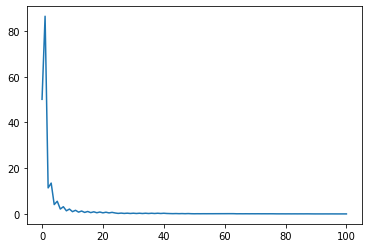

In [84]:
plt.plot(loss_track_inface)
plt.show()

# Tuned Model



In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_track_reg, label = 'Frank Wolfe')
plt.plot(loss_track_inface, label = 'In-Face Frank Wolfe')
plt.legend()
plt.show()

# Grid Searching

##Delta

In [ ]:
deltas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter=201, patience = 0.01, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 0.001    ------     Final Loss: 1995299.6906607011   at iteration 2
Delta: 0.01    ------     Final Loss: 1995296.9066038157   at iteration 2
Delta: 0.1    ------     Final Loss: 1995269.065718345   at iteration 2
Delta: 1    ------     Final Loss: 1994990.6592616318   at iteration 4
Delta: 10    ------     Final Loss: 1992207.8429168023   at iteration 19
Delta: 100    ------     Final Loss: 1964496.978598407   at iteration 84
Delta: 1000    ------     Final Loss: 1699162.6623283497   at iteration 201
Delta: 10000    ------     Final Loss: 302150.77467486466   at iteration 64
Delta: 100000    ------     Final Loss: 175474.63085276185   at iteration 70
Delta: 1000000    ------     Final Loss: 146671.28662048402   at iteration 201
Delta: 10000000    ------     Final Loss: 672843.1813172555   at iteration 201
Delta: 100000000    ------     Final Loss: 1757112480.4694064   at iteration 201


In [ ]:
deltas = [250000,
          500000,
          750000,
          1250000,
          1500000,
          2500000,
          5000000,
          7500000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter=201, patience = 0.01, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 250000    ------     Final Loss: 184966.58801373874   at iteration 142
Delta: 500000    ------     Final Loss: 169552.51866399613   at iteration 201
Delta: 750000    ------     Final Loss: 420615.6132565984   at iteration 201
Delta: 1250000    ------     Final Loss: 216412.31880627264   at iteration 201
Delta: 1500000    ------     Final Loss: 273680.42343568715   at iteration 201
Delta: 2500000    ------     Final Loss: 417712.4612960932   at iteration 201
Delta: 5000000    ------     Final Loss: 571545.4612269908   at iteration 201
Delta: 7500000    ------     Final Loss: 632556.1542439449   at iteration 201


In [ ]:
deltas = [150000,
          300000,
          450000,
          600000,
          900000,
          1200000,
          1500000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter=501, patience = 0.01, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 150000    ------     Final Loss: 180502.69121015765   at iteration 95
Delta: 300000    ------     Final Loss: 186151.14181067253   at iteration 165
Delta: 450000    ------     Final Loss: 188191.3045520871   at iteration 231
Delta: 600000    ------     Final Loss: 189243.6150128576   at iteration 297
Delta: 900000    ------     Final Loss: 190318.32554160611   at iteration 425
Delta: 1200000    ------     Final Loss: 189679.94593613478   at iteration 501
Delta: 1500000    ------     Final Loss: 149600.4326080835   at iteration 501


In [ ]:
deltas = [1750000,
          2000000,
          2250000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter = 1000, patience = 0.001, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 1750000    ------     Final Loss: 191384.43819455765   at iteration 786
Delta: 2000000    ------     Final Loss: 191527.2106760225   at iteration 889
Delta: 2250000    ------     Final Loss: 191638.53051798942   at iteration 991


In [ ]:
deltas = [1375000,
          1500000,
          1625000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter = 1000, patience = 0.001, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 1375000    ------     Final Loss: 191074.29727334835   at iteration 630
Delta: 1500000    ------     Final Loss: 191194.6863524153   at iteration 682
Delta: 1625000    ------     Final Loss: 191296.77299220837   at iteration 734


## Gammas

In [ ]:
gammas = [[0,    0.1],
          [0,    1],
          [0.1,  1],
          [1,    1],
          [1,   10],
          [1,  100],
          [10, 100]]

for gamma1, gamma2 in gammas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, gamma1 = gamma1, gamma2 = gamma2, delta = 1500000, max_iter = 500, patience = 0.001, printing = False)
  print('Gamma1: ' + str(gamma1) + '   Gamma2: ' + str(gamma2) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Gamma1: 0   Gamma2: 0.1    ------     Final Loss: 335449.4737096828   at iteration 500
Gamma1: 0   Gamma2: 1    ------     Final Loss: 335449.4737096833   at iteration 500
Gamma1: 0.1   Gamma2: 1    ------     Final Loss: 149460.45148459333   at iteration 500
Gamma1: 1   Gamma2: 1    ------     Final Loss: 149460.451484515   at iteration 500
Gamma1: 1   Gamma2: 10    ------     Final Loss: 335449.47370968235   at iteration 500
Gamma1: 1   Gamma2: 100    ------     Final Loss: 149460.4514845148   at iteration 500
Gamma1: 10   Gamma2: 100    ------     Final Loss: 149460.451484515   at iteration 500


In [ ]:
gammas = [[1,  100],
          [100, 100],
          [0.1,  100],
          [1,    1000]]

for gamma1, gamma2 in gammas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, gamma1 = gamma1, gamma2 = gamma2, delta = 1500000, max_iter = 500, patience = 0.001, printing = False)
  print('Gamma1: ' + str(gamma1) + '   Gamma2: ' + str(gamma2) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Gamma1: 1   Gamma2: 100    ------     Final Loss: 149460.45148459318   at iteration 500
Gamma1: 100   Gamma2: 100    ------     Final Loss: 149460.45148451466   at iteration 500
Gamma1: 0.1   Gamma2: 100    ------     Final Loss: 149460.4514845149   at iteration 500
Gamma1: 1   Gamma2: 1000    ------     Final Loss: 335449.4737115356   at iteration 500


In [ ]:
gammas = [[0,  100],
          [0, 1000],
          [0.1,  0.1]]

for gamma1, gamma2 in gammas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, gamma1 = gamma1, gamma2 = gamma2, delta = 1500000, max_iter = 500, patience = 0.001, printing = False)
  print('Gamma1: ' + str(gamma1) + '   Gamma2: ' + str(gamma2) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Gamma1: 0   Gamma2: 100    ------     Final Loss: 335449.47371153446   at iteration 500
Gamma1: 0   Gamma2: 1000    ------     Final Loss: 149460.4514845933   at iteration 500
Gamma1: 0.1   Gamma2: 0.1    ------     Final Loss: 149460.45148451495   at iteration 500


## Sub-Chapter